In [ ]:
import os
import mmh3
import BitVector as bv
import random
from itertools import combinations

def seededHash(value, seed=None):
    if seed:
        return mmh3.hash(value, seed)
    
    else:
        return mmh3.hash(value)

def minHash(inSet, k, seed=None):
    minHashList = [] #lists of the minumum hashes
    for x in inSet:
        hash_value = seededHash(str(x), seed)
        if len(minHashList) < k:
            minHashList.append(hash_value)
        else:
            max_index = minHashList.index(max(minHashList))
            if hash_value < minHashList[max_index]:
                minHashList[max_index] = hash_value
    return set(minHashList)



def bloomFilter(inSet, m, hs1=0, hs2=10):
    bv_filter = bv.BitVector(size=m)
    for item in inSet:
        hash1 = mmh3.hash(str(item).encode(), hs1) % m
        hash2 = mmh3.hash(str(item).encode(), hs2) % m
        bv_filter[hash1] = 1
        bv_filter[hash2] = 1
    return bv_filter


def jaccard(bv1, bv2):
    intersection = (bv1 & bv2).count_bits()
    union = (bv1 | bv2).count_bits()
    return intersection / union


series_files = ["series_one.txt","series_two.txt", "series_three.txt", "mountain_interval.txt", "north_of_boston.txt"]

#parse the words from each file and put it into sets
def parse_words(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        words = []
        for line in file:
            # Remove whitespaces and convert to lowercase
            line = line.strip().lower()
            
            # Split line into words using whitespace
            words.extend(line.split())
            
        return set(words)
#Creates list of sets where each set contains a word
word_sets = [parse_words(file_path) for file_path in series_files]

# Compute the raw set similarities    
raw_similarities = []
for set1, set2 in combinations(word_sets, 2):
    similarity = len(set1.intersection(set2)) / len(set1.union(set2))
    raw_similarities.append(similarity)

# Compute the minhash similarities for k=100, 500, 1000
minhash_similarities = {100: [], 500: [], 10000: []}
for k in [100, 500, 10000]:
    for set1, set2 in combinations(word_sets, 2):
        minhash_set1 = minHash(set1, k)
        minhash_set2 = minHash(set2, k)
        similarity = len(minhash_set1.intersection(minhash_set2)) / len(minhash_set1.union(minhash_set2))
        minhash_similarities[k].append(similarity)
        
m = 100000
# Compute the bloom filter similarities for m=100000, hs1=0, hs2=10
bloom_filters = [bloomFilter(s, m, hs1=0, hs2=10) for s in word_sets]
bloom_similarities = []
for i in range(len(bloom_filters)):
    for j in range(i+1, len(bloom_filters)):
        intersection_count = (bloom_filters[i] & bloom_filters[j]).count_bits()
        union_count = (bloom_filters[i] | bloom_filters[j]).count_bits()
        similarity = intersection_count / union_count
        bloom_similarities.append(similarity)


print("raw_similarities")
print(raw_similarities)
print("minhash_similarities")
print(minhash_similarities)
print("bloom_similarities")
print(bloom_similarities)


In [26]:
#1. First and 2nd, first and third, second and third
#the reason for going with the higher 

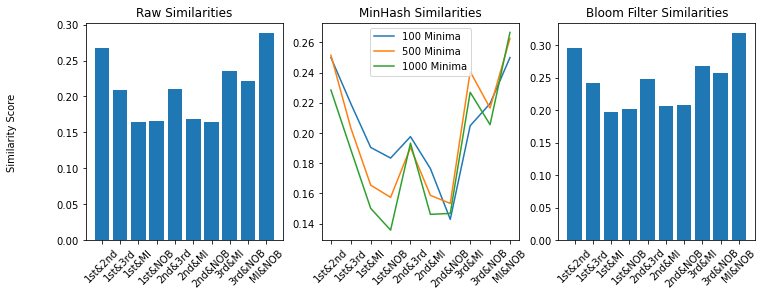

In [34]:
import matplotlib.pyplot as plt

#create a figure and three plots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

#plot raw similarities
l = len(raw_similarities)
axs[0].bar(range(l), raw_similarities)
axs[0].set_title("Raw Similarities")
axs[0].set_xticks(range(l))
axs[0].set_xticklabels(['1st&2nd', '1st&3rd', '1st&MI', '1st&NOB', '2nd&3rd', '2nd&MI', '2nd&NOB', '3rd&MI', '3rd&NOB', 'MI&NOB'], rotation=45)

#plot MinHash similarities
for k, v in minhash_similarities.items():
    axs[1].plot(range(l), v, label=f"{k} Minima")
axs[1].set_title("MinHash Similarities")
axs[1].legend()
axs[1].set_xticks(range(l))
axs[1].set_xticklabels(['1st&2nd', '1st&3rd', '1st&MI', '1st&NOB', '2nd&3rd', '2nd&MI', '2nd&NOB', '3rd&MI', '3rd&NOB', 'MI&NOB'], rotation=45)

#plot Bloom filter similarities
axs[2].bar(range(l), bloom_similarities)
axs[2].set_title("Bloom Filter Similarities")
axs[2].set_xticks(range(l))
axs[2].set_xticklabels(['1st&2nd', '1st&3rd', '1st&MI', '1st&NOB', '2nd&3rd', '2nd&MI', '2nd&NOB', '3rd&MI', '3rd&NOB', 'MI&NOB'], rotation=45)

# Set shared y-axis label and adjust subplots layout
fig.text(0.04, 0.5, "Similarity Score", ha="center", va="center", rotation="vertical")

# Show the plot
plt.show()